In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import clip
import re
import time
import yaml
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading Models")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Loading Models


In [3]:
#Our sentences we like to encode
dirname = 'europarl/'
train_path = 'train_sentences.txt'
test_path = 'test_sentences.txt'
valid_path = 'valid_sentences.txt'
train_filename = dirname + '/' + train_path
test_filename = dirname + '/' + test_path
valid_filename = dirname + '/' + valid_path

In [4]:
train_sentences = []
with open(train_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        train_sentences.append(line)
N = len(train_sentences)
print("Number of sentences to train: {}".format(N))

Number of sentences to train: 5000


In [5]:
regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
for r in regex:
    train_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), train_sentences))

In [6]:
text = clip.tokenize(train_sentences).to(device)

In [7]:
print("CLIP encoding...")
with torch.no_grad():
    clip_embeddings = clip_model.encode_text(text)

CLIP encoding...


In [8]:
print("SBERT encoding")
with torch.no_grad():  
    sbert_embeddings = torch.from_numpy(sbert_model.encode(train_sentences))

SBERT encoding


In [9]:
#Print the embeddings
print("-"*10)
for sentence, clip_embedding, sbert_embedding in zip(train_sentences[:1], clip_embeddings[:1], sbert_embeddings[:1]):
    print("Sentence:", sentence)
    print("Clip Embedding: ", clip_embedding.size())
    print("Sbert Embedding: ", sbert_embedding.size())
    print("-"*10)

----------
Sentence: I declare resumed the session of the European Parliament adjourned on Friday   December   and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period 
Clip Embedding:  torch.Size([512])
Sbert Embedding:  torch.Size([384])
----------


In [10]:
print("Creating Models to train")
model_NN_200 = SCLIPNN(200).to(device)
model_NN_250 = SCLIPNN(250).to(device)
model_NN_300 = SCLIPNN(300).to(device)
model_NN_350 = SCLIPNN(350).to(device)
model_NN_400 = SCLIPNN(400).to(device)
model_NN_450 = SCLIPNN(450).to(device)
model_NN_500 = SCLIPNN(500).to(device)
model_NN_550 = SCLIPNN(550).to(device)

Creating Models to train


In [11]:
models = {'NN200':model_NN_200, 'NN250':model_NN_250,
          'NN300':model_NN_300, 'NN350':model_NN_350,
          'NN400':model_NN_400, 'NN450':model_NN_450,
          'NN500':model_NN_500, 'NN550':model_NN_550}

In [12]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
params = cfg["training"]

def train(model, sbert_emb, clip_emb, epochs=params["epochs"], print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    losses = []
    model.train()
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_loss = 0.0
        for i, data in enumerate(zip(sbert_emb, clip_emb)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
        losses.append(epoch_loss)

        if epoch % print_every == 0:
            print("Epoch {}. Loss: {}".format(epoch, epoch_loss))
    
    print("Final Loss: {}".format(losses[-1]))
    
    return losses

In [13]:
losses = []
final_loss = []
training_time = []
for name, model in models.items():
    start_time = time.time()
    print('Training model {}'.format(name))
    loss = train(model, sbert_embeddings, clip_embeddings)
    losses.append(loss)    
    final_loss.append(round(loss[-1],3))
    end_time = time.time() - start_time
    end_time = time.gmtime(end_time)
    elapsed_time = time.strftime("%H:%M:%S", end_time)
    training_time.append(elapsed_time)
    print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
    print("-"*50)
actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
print("End of Training Process on {}".format(actual_time))

Training model NN200
Epoch 0. Loss: 608.7544033424421
Epoch 30. Loss: 185.53629218106278
Epoch 60. Loss: 168.93096141594717
Epoch 90. Loss: 158.666116521628
Epoch 120. Loss: 151.52521699110284
Final Loss: 146.4297056897221
Finished Training from model NN200. Elapsed time: 00:27:04.
--------------------------------------------------
Training model NN250
Epoch 0. Loss: 592.4259671499932
Epoch 30. Loss: 182.07014870531677
Epoch 60. Loss: 164.8055341609366
Epoch 90. Loss: 154.70549948012712
Epoch 120. Loss: 147.90925945312662
Final Loss: 143.07131876639903
Finished Training from model NN250. Elapsed time: 00:27:02.
--------------------------------------------------
Training model NN300
Epoch 0. Loss: 572.1887418747397
Epoch 30. Loss: 180.46392268411697
Epoch 60. Loss: 162.524032192386
Epoch 90. Loss: 152.1565159970978
Epoch 120. Loss: 145.18109183156224
Final Loss: 140.2299534767673
Finished Training from model NN300. Elapsed time: 00:27:07.
------------------------------------------------

TypeError: Tuple or struct_time argument required

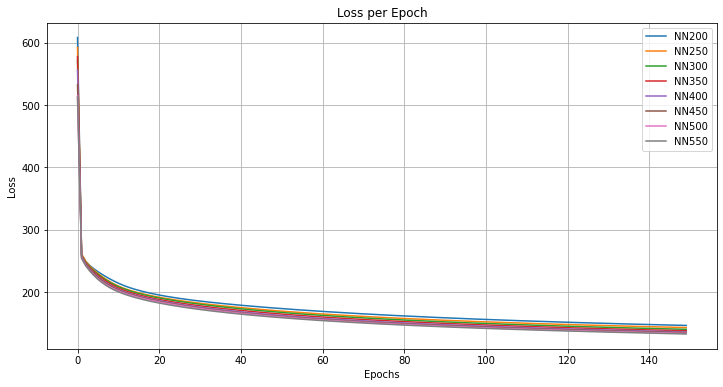

In [14]:
plt.figure(figsize=(12, 6))
for i, (name, model) in enumerate(models.items()):
    plt.plot(losses[i][0:], label = name)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid()
plt.show()

In [15]:
test_sentences = []
with open(test_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        test_sentences.append(line)
N = len(test_sentences)
print("Number of sentences to test: {}".format(N))

Number of sentences to test: 1000


In [16]:
for r in regex:
    test_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), test_sentences))

In [17]:
text = clip.tokenize(test_sentences).to(device)
with torch.no_grad():
    test_clip_embeddings = clip_model.encode_text(text)

In [18]:
with torch.no_grad():
    test_sbert_embeddings = torch.from_numpy(sbert_model.encode(test_sentences))

In [19]:
def cosin_calculator(targets, predictions):    
    cosines = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for tar, pred in zip(targets, predictions):        
        cosine = cos(tar, pred)
        cosines.append(cosine.item())
    return np.array(cosines)

In [20]:
print("Evaluating...")
cosines = []
euclideans = []
with torch.no_grad():
    for name, model in models.items():
        sum_cos = 0
        count = 0
        predictions =[]
        if len(test_clip_embeddings) == 0:
            break
        for tclip, tsbert in zip(test_clip_embeddings, test_sbert_embeddings):        
            tclip = tclip.to(device)
            tsbert = tsbert.to(device)
            prediction = model(tsbert)
            predictions.append(prediction)
            sum_cos += np.mean(cosin_calculator(tclip, prediction))
            count += 1
        cosines.append(round(sum_cos/count,3))
        stacked_predictions = torch.stack(predictions)
        euclidean = torch.cdist(test_clip_embeddings.to(float), stacked_predictions.to(float))
        avg_euclidean = torch.mean(euclidean)
        euclideans.append(round(avg_euclidean.item(),3))    

Evaluating...


In [21]:
data = {"Cosin":cosines, "Euclidean":euclideans, 
        "TrainTime":training_time, "Loss":final_loss}
results = pd.DataFrame(data, index=models.keys())

In [22]:
print(results)

       Cosin  Euclidean TrainTime     Loss
NN200  0.427      5.536  00:27:04  146.430
NN250  0.432      5.570  00:27:02  143.071
NN300  0.439      5.589  00:27:07  140.230
NN350  0.442      5.600  00:27:05  137.879
NN400  0.445      5.616  00:26:59  136.084
NN450  0.447      5.626  00:27:06  134.840
NN500  0.450      5.629  00:27:02  133.658
NN550  0.451      5.637  00:27:02  132.734


In [23]:
results

,Cosin,Euclidean,TrainTime,Loss
NN200,0.427,5.536,00:27:04,146.430
NN250,0.432,5.570,00:27:02,143.071
NN300,0.439,5.589,00:27:07,140.230
NN350,0.442,5.600,00:27:05,137.879
NN400,0.445,5.616,00:26:59,136.084
NN450,0.447,5.626,00:27:06,134.840
NN500,0.450,5.629,00:27:02,133.658
NN550,0.451,5.637,00:27:02,132.734
